<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Distributed-Information-Systems" data-toc-modified-id="Distributed-Information-Systems-0"><span class="toc-item-num">1&nbsp;&nbsp;</span>Distributed Information Systems</a></span></li><li><span><a href="#Word-Representation-for-Concept-Identification" data-toc-modified-id="Word-Representation-for-Concept-Identification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Representation for Concept Identification</a></span><ul class="toc-item"><li><span><a href="#Build-the-vocabulary-by-selecting-top-k-frequent-words" data-toc-modified-id="Build-the-vocabulary-by-selecting-top-k-frequent-words-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Build the vocabulary by selecting top-k frequent words</a></span></li><li><span><a href="#Construct-the-word-cooccurence-matrix" data-toc-modified-id="Construct-the-word-cooccurence-matrix-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Construct the word cooccurence matrix</a></span></li><li><span><a href="#Perform-SVD-on-the-matrix-and-select-the-largest-singular-values" data-toc-modified-id="Perform-SVD-on-the-matrix-and-select-the-largest-singular-values-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Perform SVD on the matrix and select the largest singular values</a></span></li></ul></li><li><span><a href="#Vector-based-retrieval-using-Word-representations" data-toc-modified-id="Vector-based-retrieval-using-Word-representations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Vector-based retrieval using Word representations</a></span><ul class="toc-item"><li><span><a href="#Document-and-query-vectors-from-word-representations" data-toc-modified-id="Document-and-query-vectors-from-word-representations-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Document and query vectors from word representations</a></span></li><li><span><a href="#Retrieve-top-10-relevant-documents" data-toc-modified-id="Retrieve-top-10-relevant-documents-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Retrieve top-10 relevant documents</a></span></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Evaluate-retrieval-result-using-DCG" data-toc-modified-id="Evaluate-retrieval-result-using-DCG-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Evaluate retrieval result using DCG</a></span></li><li><span><a href="#Explain-the-DCG-values-plot" data-toc-modified-id="Explain-the-DCG-values-plot-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Explain the DCG values plot</a></span></li></ul></li><li><span><a href="#Submit-your-notebook" data-toc-modified-id="Submit-your-notebook-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Submit your notebook</a></span></li></ul></div>

# Distributed Information Systems
***Midterm Exam, Fall-Winter Semester 2021-22***

The following materials are allowed: exercise sheets and solutions, past exams with your own solution, personally written notes and personally collected documentation.

The exam will be held on your computer, but digital communication by any means is strictly prohibited. 
By participating to this exam you agree to these conditions.

These are the instructions for the exam:

1. You are not allowed to leave the examination room in the first 20 and the last 15 minutes of the exam.
* We will publish 15 minutes before the end of the exam a password for uploading your solutions on Moodle.
* It is not recommended to leave the exam before the password is published. If you need to leave earlier, contact us.

In [1]:
#Required libraries
import math
import os
import string
from collections import defaultdict
from operator import itemgetter
from pprint import pprint

import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english')).union(set(stopwords.words('french')))

[nltk_data] Downloading package punkt to /Users/romanou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/romanou/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
def read_corpus():
    '''Reads corpus from files.'''
    
    documents = []
    orig_docs = []
    DIR = './'
    tknzr = TweetTokenizer()
    with open("epfldocs.txt", encoding = "utf-8") as f:
        content = f.readlines()
    for text in content:
        orig_docs.append(text)
        # split into words
        tokens = tknzr.tokenize(text)
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # filter out stop words
        words = [w for w in words if not w in stop_words]

        documents.append(' '.join(words))
    return documents, orig_docs

documents, orig_docs = read_corpus()

In [3]:
assert(len(documents) == 1075)

# Word Representation for Concept Identification

We will build word representations in a latent concept space using SVD. Differently to Latent Semantic Indexing (LSI) we will derive the latent concepts space from the **word co-occurrence matrix** (and not from the term-document matrix, as in standard LSI).

An entry (i,j) in the word co-occurrence matrix corresponds to the number of times the word i co-occurs with the word j in the context of word i. The context of the words consist of the words preceding or succeeding the word in the text.  

By deriving an SVD from the word co-occurrence matrix, and selecting the top dimensions of the latent space, we obtain a word representation as vectors over a concept space. Commonly such word representations are also called word embeddings.
 

## Build the vocabulary by selecting top-k frequent words
No code is required for this part.

In [4]:
# vocabulary is the list of all words
# vocabulary_to_index maps words to their index

def create_vocabulary_frequency(corpus, vocab_len):
    '''Select top-k (k = vocab_len) words in term of frequencies as vocabulary'''
    vocabulary_to_index = {}
    count = defaultdict(int)
    for document in corpus:
        for word in document.split():
                count[word] += 1
    
    sorted_count_by_freq = sorted(count.items(), key=lambda kv: kv[1], reverse=True)

    vocabulary = []
    for i, x in enumerate(sorted_count_by_freq[:vocab_len]):
        vocabulary.append(x[0])
        vocabulary_to_index[x[0]] = i
    return vocabulary, vocabulary_to_index

vocab_freq, vocabulary_to_index = create_vocabulary_frequency(documents, 5000)

## Construct the word cooccurence matrix

In this question, you need to construct the word co-occurence matrix, given the vocabulary and the set of documents.

The value of a cell (i,j) is the number of times the word i co-occurs with the word j in the context of word i.

For this question, a word $w_i$ cooccurs with a word $w_j$ in the context of word $w_i$ if $w_j$ preceeds or succeeds $w_i$ with a distance **at most 2**.

Example: For this document "*how to bake bread without bake recip*", the words coocur with the word "*bread*" are "*to, bake, without, bake*".

Make sure that you consider only words that appear in the vocabulary.

In [5]:
def construct_word_cooccurence_matrix(vocabulary_to_index, documents, k=2):
    matrix = np.zeros((len(vocabulary_to_index), len(vocabulary_to_index)))
    for document in documents:
        terms = document.split()
        for ind, term_i in enumerate(terms):
            if term_i in vocabulary_to_index:
                for context_ind in range(max(0, ind-2), min(len(terms), ind+3)):
                    if context_ind != ind and terms[context_ind] in vocabulary_to_index:
                        matrix[vocabulary_to_index[term_i], vocabulary_to_index[terms[context_ind]]] += 1
    return matrix

word_cooccur_matrix = construct_word_cooccurence_matrix(vocabulary_to_index, documents)

You can optionally check whether the matrix you constructed is correct using the following code:

In [6]:
assert_matrix = False
if assert_matrix:
    word_coor_mat = np.load("word_coocur_matrix.npy")
    assert(word_coor_mat == word_cooccur_matrix[:100,:100]).all()

## Perform SVD on the matrix and select the largest singular values 

We perform SVD on the matrix $\mathbf{M} = \mathbf{K}\mathbf{S}\mathbf{D}^T$ and select the first 128 largest singular values.

Then, we can use the submatrix $\mathbf{K_s}$, corresponding to the largest singular values, as the word representation matrix. 

Hint 1 : Are the words represented in $\mathbf{K_s}$ as rows or columns?

Hint 2: np.linalg.svd(M, full_matrices=False) performs SVD on the matrix $\mathbf{M}$ and returns $\mathbf{K}, \mathbf{S}, \mathbf{D}^T$

 -  $\mathbf{K}, \mathbf{D}^T$ are matrices with orthonormal columns
 -  $\mathbf{S}$ is a **vector** of singular values in a **descending** order
 
Hint 3: np.diag(V) converts a vector to a diagonal matrix

Hint 4: To select:
 - the first k rows of a matrix A, use A[0:k, :]
 - the first k columns of a matrix A, use A[:, 0:k]
 - the submatrix from first k rows and k columns of a matrix A, use A[0:k, 0:k]

In [7]:
# Input: a word coocurrence matrix and the number of singular values that will be selected
# Output: K_s, S_s, Dt_s are similar to the defintion in the lecture

def truncated_svd(word_cooccur_matrix, num_val):
    # The following may take 1-2 minutes since we are decomposing a matrix of size 5000x1075
    K, S, Dt = np.linalg.svd(word_cooccur_matrix, full_matrices=False) 
    
    K_sel = K[:, :num_val]
    S_sel = np.diag(S)[:num_val, :num_val]
    Dt_sel = Dt[:num_val, :]
    return K_sel, S_sel, Dt_sel

K_s, S_s, Dt_s = truncated_svd(word_cooccur_matrix,128)

# Vector-based retrieval using Word representations



## Document and query vectors from word representations

For each document and query, we construct the corresponding vector by **averaging** its word representations.

Hint: not all words are in the vocabulary!

In [9]:
def get_doc_vecs(documents, word_embedding_matrix, vocabulary_to_index):
    doc_vecs = np.zeros((len(documents), word_embedding_matrix.shape[1]))

    w_emb = lambda w: word_embedding_matrix[vocabulary_to_index[w]] if w in vocabulary_to_index else np.zeros((word_embedding_matrix.shape[1]))
    d_emb = lambda d: np.average(list(map(w_emb, d.split()+[''])), axis=0)

    doc_vecs = np.stack(list(map(d_emb, documents)), axis=0)
    
    return doc_vecs

doc_vecs = get_doc_vecs(documents, K_s, vocabulary_to_index)

## Retrieve top-10 relevant documents

Retrieve top-10 relevant documents for the query "*computer science*"

Hint: you may use the function get_doc_vecs

In [10]:
query = "computer science"

query_vec = get_doc_vecs([query], K_s, vocabulary_to_index)[0]

In [11]:
def cosine_similarity(v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy*1.0/math.sqrt(sumxx*sumyy)

def retrieve_documents(doc_vecs, query_vec, top_k):
    scores = [[cosine_similarity(query_vec, doc_vecs[d,:]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    doc_ids = []
    retrieved = []
    for i in range(top_k):
        doc_ids.append(scores[i][1])
        retrieved.append(orig_docs[scores[i][1]])
    return doc_ids, retrieved

retrieved_ids, retrieved_docs = retrieve_documents(doc_vecs, query_vec, top_k=10)

/Users/smeros/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


# Evaluation
We consider the scikit reference code as an “oracle” that supposedly gives the correct result. 

In [12]:
# Retrieval oracle 
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), vocabulary=vocab_freq, min_df = 1, stop_words = 'english')
features = tf.fit_transform(documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, features, threshold=0.1):
    new_features = tf.transform([query])
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold:
            break
        doc_ids.append(related_docs_indices[i])
    return doc_ids

# gt_ids are the document ids retrieved by the oracle
gt_ids = search_vec_sklearn(query, features)

We also assume that there is a user that has done the grading of all the documents according to their relevance. 
The top-10 results using scikit-learn have grade 3, the next 10 results have grade 2, 
the rest in the list has grade 1 while non-relevant results have grade 0.

In [13]:
grade = []
for i in range(len(documents)):
    if i in gt_ids[:10]:
        grade.append(3)
    elif i in gt_ids[10:20]:
        grade.append(2)
    elif i in gt_ids[20:]:
        grade.append(1)
    else:
        grade.append(0)

## Evaluate retrieval result using DCG 

Discounted Cumulative Gain (DCG) is a retrieval metric that also takes into account the ordering of the result. 

The DCG accumulated at a rank $k$ is defined as:

$DCG_k = \sum_{i=1}^k \frac{grade[i]}{log_2(i+1)}$

where $grade[i]$ is the relevance score given by the user for the result at position $i$.

Hint: the logarithm is computed using the function np.log2

In [14]:
def dcg(k, retrieved_ids, grade):
    dcg_val = 0
    for i in range(1, k):
        dcg_val += grade[i] / math.log2(i+1)
    return dcg_val

We compute the DCG for the top-1 to the top-10 retrieval results and we plot the values.

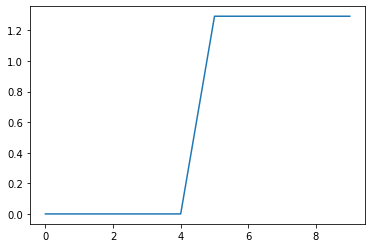

In [15]:
vals = []
for i in range(10):
    val = dcg(i, retrieved_ids, grade)
    vals.append(val)
    
plt.plot(vals)

## Explain the DCG values plot

# Submit your notebook

Go to [Moodle](https://moodle.epfl.ch/course/view.php?id=4051) > Exams > Midterm and follow the instructions.
